## Traininig the Inclusive classifier with tf.keras using data in TFRecord format

**tf.keras Inclusive classifier, GRU-based model** This notebooks trains a neural network for a particle classifier using the Inclusive Classifier model, using as input the full list of reconstructed particles + the High Level Features. Data is prepared in TFRecord format converting from Parquet using Apache Spark. Tensorflow data procesing uses tf.data and tf.io.  

Credits: this notebook is part of the work: 
- [Machine Learning Pipelines with Modern Big Data Tools for High Energy Physics Comput Softw Big Sci 4, 8 (2020)](https://rdcu.be/b4Wk9)  
- Code and data at:https://github.com/cerndb/SparkDLTrigger  

The model is a classifier implemented as the concatenation of a Dense Neural Network and a Recurrent Neural Network (GRU)
 - input: 14 high-level features and an array of 801 particles with 19 low-level features, described in [ Topology classification with deep learning to improve real-time event selection at the LHC](https://link.springer.com/epdf/10.1007/s41781-019-0028-1?author_access_token=eTrqfrCuFIP2vF4nDLnFfPe4RwlQNchNByi7wbcMAY7NPT1w8XxcX1ECT83E92HWx9dJzh9T9_y5Vfi9oc80ZXe7hp7PAj21GjdEF2hlNWXYAkFiNn--k5gFtNRj6avm0UukUt9M9hAH_j4UR7eR-g%3D%3D)
 - output: 3 classes, "W + jet", "QCD", "t tbar", see also [Machine Learning Pipelines with Modern Big Data Tools for High Energy Physics Comput Softw Big Sci 4, 8 (2020)](https://rdcu.be/b4Wk9)  
 - Open dataset: [download data](https://github.com/cerndb/SparkDLTrigger/tree/master/Data)


## Create the Keras model for the inclusive classifier

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.layers import Masking, Dense, Activation, GRU, Dropout, concatenate

In [2]:
tf.version.VERSION

'2.8.0'

In [3]:
# Check that we have a GPU available
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
## GRU branch
gru_input = Input(shape=(801,19), name='gru_input')
a = gru_input
a = Masking(mask_value=0.)(a)
a = GRU(units=50,activation='tanh')(a)
gruBranch = Dropout(0.2)(a)

In [5]:
hlf_input = Input(shape=(14,), name='hlf_input')
b = hlf_input
hlfBranch = Dropout(0.2)(b)

In [6]:
c = concatenate([gruBranch, hlfBranch])
c = Dense(25, activation='relu')(c)
output = Dense(3, activation='softmax')(c)

In [7]:
model = Model(inputs=[gru_input, hlf_input], outputs=output)

In [8]:
## Compile model
optimizer = 'Adam'
loss = 'categorical_crossentropy'
model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"] )

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 gru_input (InputLayer)         [(None, 801, 19)]    0           []                               
                                                                                                  
 masking (Masking)              (None, 801, 19)      0           ['gru_input[0][0]']              
                                                                                                  
 gru (GRU)                      (None, 50)           10650       ['masking[0][0]']                
                                                                                                  
 hlf_input (InputLayer)         [(None, 14)]         0           []                               
                                                                                              

## Load test and training data in TFRecord format, using tf.data and tf.io

In [10]:
# Download the datasets from 
# ** https://github.com/cerndb/SparkDLTrigger/tree/master/Data **
#
# For CERN users, data is already available on EOS
FOLDER = "/eos/project/s/sparkdltrigger/public/"

PATH = FOLDER + "testUndersampled_InclusiveClassifier.tfrecord"
files_test_dataset = tf.data.Dataset.list_files(PATH+"/part-r*", shuffle=False)

# training dataset 
PATH = FOLDER + "trainUndersampled_InclusiveClassifier.tfrecord"
files_train_dataset = tf.data.Dataset.list_files(PATH+"/part-r*", seed=4242)

In [11]:
# tunable
num_parallel_reads=8

test_dataset = files_test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE).interleave(
    tf.data.TFRecordDataset, 
    cycle_length=num_parallel_reads,
    num_parallel_calls=tf.data.experimental.AUTOTUNE)

train_dataset = files_train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE).interleave(
    tf.data.TFRecordDataset, cycle_length=num_parallel_reads,
    num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [12]:
# Function to decode TFRecord data into the required features and labels
# In particular, GRU_input is stored has a flat array and needs to be resized as (801,19)

def decode(serialized_example):
    deser_features = tf.io.parse_single_example(
      serialized_example,
      features={
          'HLF_input': tf.io.FixedLenFeature((14), tf.float32),
          'GRU_input': tf.io.FixedLenFeature((801,19), tf.float32),
          'encoded_label': tf.io.FixedLenFeature((3), tf.float32),
          })
    return((deser_features['GRU_input'], deser_features['HLF_input']), deser_features['encoded_label'])

In [13]:
# use for debug
# for record in test_dataset.take(1):
#     print(record)

In [14]:
parsed_test_dataset=test_dataset.map(decode, num_parallel_calls=tf.data.experimental.AUTOTUNE)
parsed_train_dataset=train_dataset.map(decode, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [15]:
# Show and example of the parsed data
# for record in parsed_test_dataset.take(1):
#     print(record)

In [16]:
# tunable
batch_size=128

train=parsed_train_dataset.batch(batch_size)
train=train.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
train

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 801, 19), dtype=tf.float32, name=None), TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [17]:
# tunable
test_batch_size = 10240

test=parsed_test_dataset.batch(batch_size)
test=test.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## Train the tf.keras model

In [18]:
# train the Keras model

# tunable
num_epochs = 6

# callbacks = [ tf.keras.callbacks.TensorBoard(log_dir='./logs') ]
callbacks = []
    
%time history = model.fit(train, validation_data=test, epochs=num_epochs, callbacks=callbacks)


Epoch 1/6
26767/26767 [==============================] - 1048s 39ms/step - loss: 0.2333 - accuracy: 0.9134 - val_loss: 0.1587 - val_accuracy: 0.9418
Epoch 2/6
26767/26767 [==============================] - 1045s 39ms/step - loss: 0.1526 - accuracy: 0.9449 - val_loss: 0.1326 - val_accuracy: 0.9520
Epoch 3/6
26767/26767 [==============================] - 1102s 41ms/step - loss: 0.1382 - accuracy: 0.9504 - val_loss: 0.1243 - val_accuracy: 0.9557
Epoch 4/6
26767/26767 [==============================] - 1075s 40ms/step - loss: 0.1333 - accuracy: 0.9522 - val_loss: 0.1209 - val_accuracy: 0.9566
Epoch 5/6
26767/26767 [==============================] - 1082s 40ms/step - loss: 0.1300 - accuracy: 0.9535 - val_loss: 0.1270 - val_accuracy: 0.9541
Epoch 6/6
26767/26767 [==============================] - 1080s 40ms/step - loss: 0.1274 - accuracy: 0.9543 - val_loss: 0.1187 - val_accuracy: 0.9574
CPU times: user 2h 37min 38s, sys: 1h 59min 27s, total: 4h 37min 5s
Wall time: 1h 47min 32s


In [ ]:
# Save the model
# tf.keras.models.save_model(model, "./myGRUmodel" + ".tf", save_format='tf')

## Performance metrics

<IPython.core.display.Javascript object>


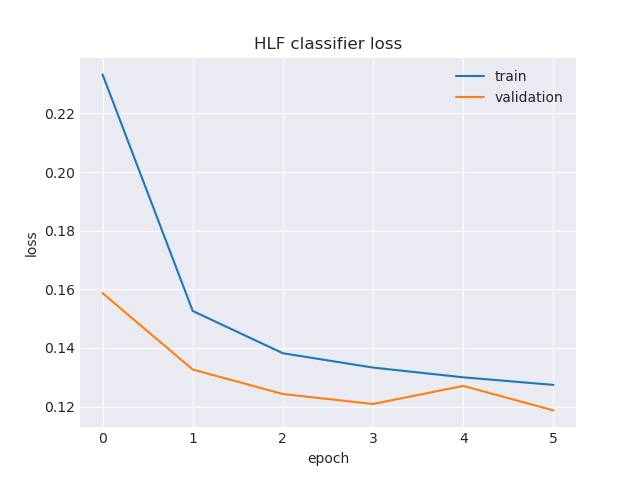

In [20]:
%matplotlib notebook
import matplotlib.pyplot as plt 
plt.style.use('seaborn-darkgrid')

# Graph with loss vs. epoch

plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.title("HLF classifier loss")
plt.show()

<IPython.core.display.Javascript object>


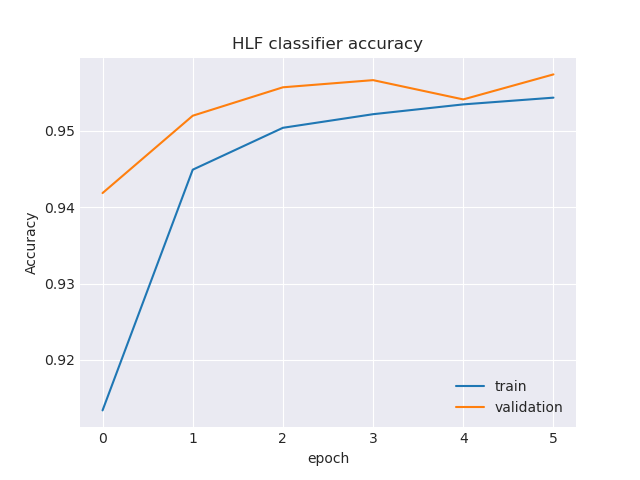

In [21]:
# Graph with accuracy vs. epoch
%matplotlib notebook
plt.figure()
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.title("HLF classifier accuracy")
plt.show()

## Confusion Matrix

In [22]:
# model = tf.keras.models.load_model("./mymodel.tf")

In [23]:
%time model.evaluate(test)

6689/6689 [==============================] - 159s 24ms/step - loss: 0.1187 - accuracy: 0.9574
CPU times: user 3min 38s, sys: 3min 29s, total: 7min 7s
Wall time: 2min 39s


[0.1186830997467041, 0.9573876857757568]

In [24]:
%time y_pred = model.predict(test)

CPU times: user 3min 28s, sys: 3min 25s, total: 6min 53s
Wall time: 3min 3s


In [25]:
%time y_true = np.stack([labels.numpy() for features,labels in parsed_test_dataset.__iter__()])

CPU times: user 4min 25s, sys: 3min 56s, total: 8min 22s
Wall time: 3min 31s


In [26]:
from sklearn.metrics import accuracy_score

print('Accuracy of the classifier: {:.4f}'.format(
    accuracy_score(np.argmax(y_true, axis=1),np.argmax(y_pred, axis=1))))

Accuracy of the classifier: 0.9574


/tmp/ipykernel_1461/950292951.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cm = cm / cm.astype(np.float).sum(axis=1)


<IPython.core.display.Javascript object>


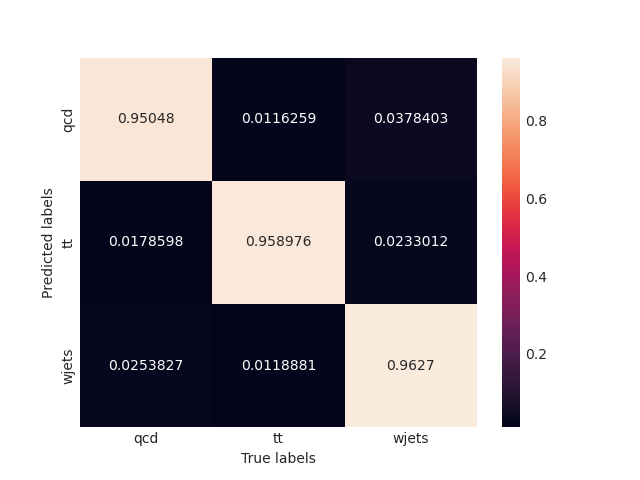

In [27]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
labels_name = ['qcd', 'tt', 'wjets']
labels = [0,1,2]

cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), labels=labels)

## Normalize CM
cm = cm / cm.astype(np.float).sum(axis=1)

fig, ax = plt.subplots()
ax = sns.heatmap(cm, annot=True, fmt='g')
ax.xaxis.set_ticklabels(labels_name)
ax.yaxis.set_ticklabels(labels_name)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

## ROC and AUC

In [28]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [29]:
# Dictionary containign ROC-AUC for the three classes 
roc_auc

{0: 0.9951801360231233, 1: 0.9970102766469089, 2: 0.9948498032171604}

<IPython.core.display.Javascript object>


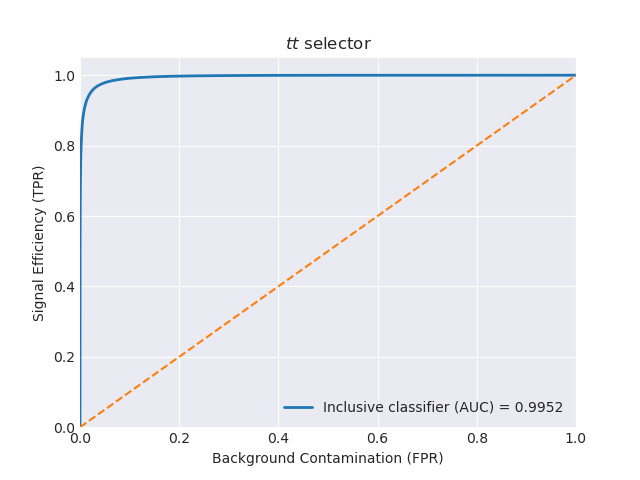

In [30]:
%matplotlib notebook

# Plot roc curve 
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

plt.figure()
plt.plot(fpr[0], tpr[0], lw=2, 
         label='Inclusive classifier (AUC) = %0.4f' % roc_auc[0])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background Contamination (FPR)')
plt.ylabel('Signal Efficiency (TPR)')
plt.title('$tt$ selector')
plt.legend(loc="lower right")
plt.show()